In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import numpy as np
import os
import scipy.io
from scipy.signal import butter, lfilter

In [2]:
# Load DEAP dataset (Change path accordingly)
data_path = "/kaggle/input/deap-matlab/"
subject_data = []
subject_labels = []

# Load all 32 subjects
for i in range(1, 33):
    mat = scipy.io.loadmat(f"{data_path}s{i:02d}.mat")
    
    # Extract EEG data and labels
    subject_data.append(mat["data"])     # Shape: (40 trials, 40 channels, 8064 samples)
    subject_labels.append(mat["labels"]) # Shape: (40 trials, 4 labels)

# Convert lists to NumPy arrays
subject_data = np.array(subject_data)     # Expected Shape: (32, 40, 40, 8064)
subject_labels = np.array(subject_labels) # Expected Shape: (32, 40, 4)

# Print shapes to confirm
print("EEG Data Shape:", subject_data.shape)   # (32, 40, 40, 8064)
print("Labels Shape:", subject_labels.shape)   # (32, 40, 4)


EEG Data Shape: (32, 40, 40, 8064)
Labels Shape: (32, 40, 4)


In [3]:
import numpy as np
import scipy.signal

# Frequency band definitions
freq_bands = {
    "delta": (1, 4),
    "theta": (4, 8),
    "alpha": (8, 14),
    "beta": (14, 30),
    "gamma": (31, 50),
}

# Function to compute Differential Entropy (DE)
def compute_de(signal):
    """Compute Differential Entropy (DE) for a given EEG segment"""
    variance = np.var(signal, axis=-1, keepdims=True)  # Compute variance
    de = 0.5 * np.log(2 * np.pi * np.e * variance)  # Apply DE formula
    return de.squeeze()  # Remove extra dimensions

# Optimized function to extract DE features
def extract_de_features(subject_data, fs=128, window_size=128):
    """
    Extract DE features from EEG data.
    - subject_data: EEG data of shape (32, 40, 40, 8064)
    - fs: Sampling frequency (128 Hz)
    - window_size: 1 second (128 samples)
    Returns: DE feature array of shape (32, 40, 40, 5, 63)
    """
    num_subjects, num_trials, num_channels, num_samples = subject_data.shape
    num_bands = len(freq_bands)
    num_windows = num_samples // window_size  # 8064 / 128 = 63 windows

    # Initialize DE feature array
    de_features = np.zeros((num_subjects, num_trials, num_channels, num_bands, num_windows), dtype=np.float32)

    # Generate bandpass filters in advance
    filter_coeffs = {band: scipy.signal.butter(4, [low, high], btype="bandpass", fs=fs, output="sos") 
                     for band, (low, high) in freq_bands.items()}

    # Reshape EEG data into (windows) for efficient processing
    subject_data_reshaped = subject_data.reshape(num_subjects, num_trials, num_channels, num_windows, window_size)

    # Loop through subjects, trials, and channels
    for b_idx, (band, sos) in enumerate(filter_coeffs.items()):
        # Apply bandpass filter to the entire dataset at once
        filtered_data = scipy.signal.sosfiltfilt(sos, subject_data, axis=-1)  # Apply zero-phase filtering

        # Reshape and compute DE for each window
        segmented_data = filtered_data.reshape(num_subjects, num_trials, num_channels, num_windows, window_size)
        de_features[..., b_idx, :] = compute_de(segmented_data)  # Vectorized DE computation

    return de_features

# Extract DE features
de_features = extract_de_features(subject_data)

# Print shape to confirm
print("DE Feature Shape:", de_features.shape)  # Expected: (32, 40, 40, 5, 63)

DE Feature Shape: (32, 40, 40, 5, 63)


In [4]:
# Define save paths (update paths as needed)
save_path = "/kaggle/working/"  # Change this if needed

# Save DE features and labels as NumPy files
np.save(save_path + "de_features.npy", de_features)  # Shape: (32, 40, 40, 5, 63)
np.save(save_path + "de_labels.npy", subject_labels) # Shape: (32, 40, 4)

print("Saved DE features and labels successfully!")

Saved DE features and labels successfully!


In [31]:
# Load DE features (assuming saved as .npy)
de_features = np.load("/kaggle/working/de_features.npy")  # (32, 40, 40, 5, 63)
de_labels = np.load("/kaggle/working/de_labels.npy")      # (32, 40, 4)

In [35]:
# import torch
# import torch.nn as nn
# import torch.optim as optim

# # Define MLP Model
# class CommonFeatureExtractor(nn.Module):
#     """Extracts common features from EEG signals"""
#     def __init__(self, input_dim=200, output_dim=64):
#         super(CommonFeatureExtractor, self).__init__()
#         self.fc1 = nn.Linear(input_dim, 256)
#         self.fc2 = nn.Linear(256, 128)
#         self.fc3 = nn.Linear(128, output_dim)
#         self.activation = nn.LeakyReLU()

#     def forward(self, x):
#         x = self.activation(self.fc1(x))
#         x = self.activation(self.fc2(x))
#         x = self.activation(self.fc3(x))
#         return x

# # Load DE features (assuming saved as .npy)
# #de_features = np.load("/kaggle/working/de_features.npy")  # (32, 40, 40, 5, 63)
# #de_labels = np.load("/kaggle/working/de_labels.npy")      # (32, 40, 4)

# # Convert to PyTorch tensors
# de_features = torch.tensor(de_features, dtype=torch.float32)  # (32, 40, 40, 5, 63)
# print(de_features.shape)

# # Reshape to (Subjects, Trials, 63, 200) → Flatten channels & bands
# num_subjects, num_trials, num_channels, num_bands, num_windows = de_features.shape
# de_features = de_features.view(num_subjects, num_trials, num_windows, num_channels * num_bands)  # (32, 40, 200, 63)
# print(de_features.shape)
# # Initialize MLP model
# mlp = CommonFeatureExtractor(input_dim=200)

# # Forward pass through MLP
# common_features = mlp(de_features)  # Output shape: (32, 40, 64, 63)

# # Print shape to verify
# print("Common Feature Shape:", common_features.shape)  # Expected: (32, 40, 64, 63)


torch.Size([32, 40, 40, 5, 63])
torch.Size([32, 40, 63, 200])
Common Feature Shape: torch.Size([32, 40, 63, 64])


In [36]:
# import torch
# import torch.nn.functional as F

# def contrastive_loss(q, tau=0.1):
#     """
#     Computes contrastive loss for a batch of embeddings.
#     Args:
#         q: Feature embeddings (batch_size, feature_dim)
#         tau: Temperature parameter (default 0.1)
#     Returns:
#         Contrastive loss scalar
#     """
#     batch_size = q.shape[0]
    
#     # Normalize embeddings to prevent large similarity values
#     q = F.normalize(q, dim=-1)  

#     # Compute cosine similarity matrix
#     sim_matrix = torch.mm(q, q.T)  # Shape: (batch, batch)

#     # Mask self-similarity (set diagonal to small negative value instead of -inf)
#     mask = torch.eye(batch_size, dtype=torch.bool, device=q.device)
#     sim_matrix.masked_fill_(mask, -5.0)  # Avoid inf in log

#     # Compute contrastive loss (with small epsilon to prevent log(0))
#     exp_sim = torch.exp(sim_matrix / tau)
#     loss = -torch.log(exp_sim / (exp_sim.sum(dim=-1, keepdim=True) + 1e-9)).mean()
    
#     return loss

# # Example: Apply Contrastive Loss on Extracted Features
# batch_size = 128  # Define batch size
# feature_dim = 64  # Output feature size from MLP

# # Simulate a batch of feature embeddings (random for now)
# q = torch.randn(batch_size, feature_dim).to(torch.float32)  

# # Compute contrastive loss
# loss = contrastive_loss(q)
# print("Contrastive Loss:", loss.item())  # Should be a finite value


Contrastive Loss: 6.006791591644287


In [38]:
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F

# Contrastive Loss with Stability Fixes
class ContrastiveLoss(nn.Module):
    def __init__(self, tau=1.0):  # Increased tau
        super(ContrastiveLoss, self).__init__()
        self.tau = tau

    def forward(self, q, labels=None):
        batch_size = q.shape[0]
        q = F.normalize(q, dim=-1)
        sim_matrix = torch.mm(q, q.T)

        # Debug: Check sim_matrix range
        print("🔥 sim_matrix range:", sim_matrix.min().item(), sim_matrix.max().item())

        # Mask self-similarity
        mask = torch.eye(batch_size, dtype=torch.bool, device=q.device)
        sim_matrix.masked_fill_(mask, -5.0)

        exp_sim = torch.exp(sim_matrix / self.tau)

        # Self-supervised contrastive loss
        if labels is None:
            loss = -torch.log(exp_sim / (exp_sim.sum(dim=-1, keepdim=True) + 1e-9)).mean()
        
        # Supervised contrastive loss
        else:
            mask_same_class = labels.unsqueeze(1) == labels.unsqueeze(0)
            mask_same_class = mask_same_class.float()

            # Debug: Check mask values
            print("🔥 mask_same_class sum:", mask_same_class.sum(dim=-1))

            exp_sim_same = exp_sim * mask_same_class
            loss = -torch.log((exp_sim_same.sum(dim=-1) + 1e-9) / (exp_sim.sum(dim=-1) + 1e-9)).mean()

        return loss

# Feature Extractor with Stability Fixes
class CommonFeatureExtractor(nn.Module):
    def __init__(self, input_dim=200, output_dim=64):
        super(CommonFeatureExtractor, self).__init__()
        self.fc1 = nn.Linear(input_dim, 256)
        self.ln1 = nn.LayerNorm(256)  
        self.fc2 = nn.Linear(256, 128)
        self.ln2 = nn.LayerNorm(128)
        self.fc3 = nn.Linear(128, output_dim)
        self.activation = nn.LeakyReLU()
        self.dropout = nn.Dropout(0.3)

    def forward(self, x):
        x = self.activation(self.ln1(self.fc1(x)))
        x = self.dropout(x)
        x = self.activation(self.ln2(self.fc2(x)))
        x = self.fc3(x)
        x = F.normalize(x, dim=-1)  # Ensure normalized embeddings
        return torch.where(torch.isnan(x), torch.zeros_like(x), x)  # Replace NaN values

# Training Setup
batch_size = 128
feature_dim = 200
common_feature_dim = 64
epochs = 50
lr = 0.001

# Load Real DE Features
de_features = torch.tensor(de_features, dtype=torch.float32)  # (32, 40, 63, 200)
labels = torch.tensor(subject_labels[:, :, 0], dtype=torch.long)  # (32, 40)

# Initialize Model & Optimizer
mlp = CommonFeatureExtractor(input_dim=feature_dim, output_dim=common_feature_dim)
optimizer = optim.Adam(mlp.parameters(), lr=lr)
contrastive_criterion = ContrastiveLoss(tau=0.5)

# Reshape Data
all_features = de_features.view(-1, 63, 200)  # (1280, 63, 200)
all_labels = labels.view(-1)  # (1280,)

# Training Loop
for epoch in range(epochs):
    optimizer.zero_grad()

    # Sample a batch
    batch_indices = torch.randint(0, all_features.shape[0], (batch_size,))
    batch_data = all_features[batch_indices]  # (batch_size, 63, 200)
    batch_labels = all_labels[batch_indices]  # (batch_size,)

    # Flatten for MLP input
    batch_data = batch_data.view(batch_size * 63, feature_dim)

    # Fix NaNs and Infs
    batch_data = torch.where(torch.isnan(batch_data), torch.zeros_like(batch_data), batch_data)
    batch_data = torch.where(torch.isinf(batch_data), torch.zeros_like(batch_data), batch_data)

    # Extract Features
    common_features = mlp(batch_data)

    # Fix NaNs and Infs
    common_features = torch.where(torch.isnan(common_features), torch.zeros_like(common_features), common_features)
    common_features = torch.where(torch.isinf(common_features), torch.zeros_like(common_features), common_features)

    # Compute Loss
    if epoch < 25:
        loss = contrastive_criterion(common_features)  # Self-supervised
    else:
        loss = contrastive_criterion(common_features, batch_labels.repeat(63))  # Supervised

    loss.backward()
    optimizer.step()

    print(f"Epoch {epoch+1}/{epochs} - Contrastive Loss: {loss.item():.4f}")

print("✅ Training Complete!")

<ipython-input-38-76817c9393ba>:71: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  de_features = torch.tensor(de_features, dtype=torch.float32)  # (32, 40, 63, 200)


🔥 sim_matrix range: -0.03080647811293602 1.0000005960464478
Epoch 1/50 - Contrastive Loss: 9.0087
🔥 sim_matrix range: 0.4730285406112671 1.0000004768371582
Epoch 2/50 - Contrastive Loss: 8.9987
🔥 sim_matrix range: 0.5490142703056335 1.0000004768371582
Epoch 3/50 - Contrastive Loss: 8.9972
🔥 sim_matrix range: 0.7217415571212769 1.0000004768371582
Epoch 4/50 - Contrastive Loss: 8.9969
🔥 sim_matrix range: 0.7994238138198853 1.0000004768371582
Epoch 5/50 - Contrastive Loss: 8.9967
🔥 sim_matrix range: 0.8583642244338989 1.0000004768371582
Epoch 6/50 - Contrastive Loss: 8.9967
🔥 sim_matrix range: 0.8812532424926758 1.0000004768371582
Epoch 7/50 - Contrastive Loss: 8.9966
🔥 sim_matrix range: 0.9011660218238831 1.0000004768371582
Epoch 8/50 - Contrastive Loss: 8.9966
🔥 sim_matrix range: 0.9070790410041809 1.0000004768371582
Epoch 9/50 - Contrastive Loss: 8.9966
🔥 sim_matrix range: 0.9069759249687195 1.0000005960464478
Epoch 10/50 - Contrastive Loss: 8.9966
🔥 sim_matrix range: 0.922047615051269

/usr/local/lib/python3.10/dist-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


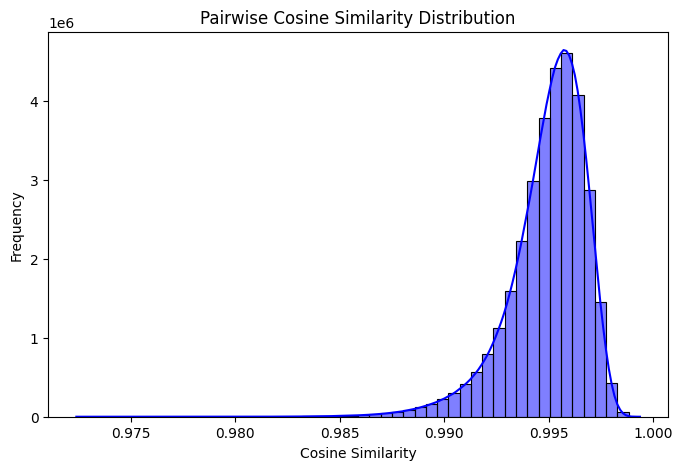

Mean Similarity: 0.9949, Variance: 0.0000


In [39]:
import torch
import matplotlib.pyplot as plt
import seaborn as sns

def check_overclustering(embeddings):
    """
    Compute pairwise cosine similarity and plot histogram.
    """
    # Detach and move to CPU
    embeddings = embeddings.detach().cpu()
    
    # Normalize embeddings
    embeddings = torch.nn.functional.normalize(embeddings, p=2, dim=-1)
    
    # Compute cosine similarity matrix
    sim_matrix = torch.matmul(embeddings, embeddings.T).numpy()

    # Flatten upper triangle (excluding diagonal)
    triu_indices = torch.triu_indices(*torch.tensor(sim_matrix.shape), offset=1)
    sim_values = sim_matrix[triu_indices[0], triu_indices[1]]

    # Plot similarity distribution
    plt.figure(figsize=(8, 5))
    sns.histplot(sim_values, bins=50, kde=True, color="blue")
    plt.xlabel("Cosine Similarity")
    plt.ylabel("Frequency")
    plt.title("Pairwise Cosine Similarity Distribution")
    plt.show()

    # Print mean and variance of similarities
    print(f"Mean Similarity: {sim_values.mean():.4f}, Variance: {sim_values.var():.4f}")

# Call this function with detached features
check_overclustering(common_features)

In [54]:
import torch
import torch.nn as nn

# Define Subject-Specific Feature Extractor (SFE)
class SubjectSpecificFeatureExtractor(nn.Module):
    def __init__(self, input_dim=64, output_dim=32):
        super(SubjectSpecificFeatureExtractor, self).__init__()
        self.fc = nn.Linear(input_dim, output_dim)  # Linear layer: 64 → 32
        self.activation = nn.LeakyReLU()  # Apply LeakyReLU activation

    def forward(self, x):
        """
        Forward pass for SFE
        x: Input tensor of shape (batch_size, trials, time_windows, 64)
        Output: Transformed features of shape (batch_size, trials, time_windows, 32)
        """
        x = self.fc(x)  # Linear transformation
        x = self.activation(x)  # Apply LeakyReLU
        return x

# Simulated input tensor (batch_size=32, trials=40, time_windows=63, feature_dim=64)
input_features = torch.randn(32, 40, 63, 64)  # (Subjects, Trials, Time Windows, Feature Dim)

# Initialize SFE model
sfe = SubjectSpecificFeatureExtractor()

# Forward pass through SFE
subject_specific_features = sfe(input_features)

# Print output shape to verify
print("SFE Output Shape:", subject_specific_features.shape)  # Expected: (32, 40, 63, 32)


SFE Output Shape: torch.Size([32, 40, 63, 32])


In [55]:
# Define Subject-Specific Classifier (SSC)
class SubjectSpecificClassifier(nn.Module):
    def __init__(self, input_dim=32, num_classes=4):
        super(SubjectSpecificClassifier, self).__init__()
        self.fc = nn.Linear(input_dim, num_classes)  # Linear layer: 32 → 4

    def forward(self, x):
        """
        Forward pass for SSC
        x: Input tensor of shape (batch_size, trials, time_windows, 32)
        Output: Logits of shape (batch_size, trials, time_windows, 4)
        """
        x = self.fc(x)  # Linear transformation (No activation)
        return x

# Initialize SSC model
ssc = SubjectSpecificClassifier()

# Forward pass through SSC
ssc_output = ssc(subject_specific_features)  # Input: (32, 40, 63, 32)

# Print output shape to verify
print("SSC Output Shape:", ssc_output.shape)  # Expected: (32, 40, 63, 4)


SSC Output Shape: torch.Size([32, 40, 63, 4])


In [56]:
# Define MMD Loss Function
import torch

def mmd_loss(source_features, target_features):
    """
    Compute Maximum Mean Discrepancy (MMD) loss.
    - source_features: Tensor of shape (batch_size, trials, time_windows, feature_dim=32)
    - target_features: Tensor of shape (batch_size, trials, time_windows, feature_dim=32)
    Returns:
        MMD loss scalar
    """
    batch_size, trials, time_windows, feature_dim = source_features.shape

    # Compute mean embeddings
    source_mean = source_features.mean(dim=(0, 1, 2))  # Average over batch, trials, time windows
    target_mean = target_features.mean(dim=(0, 1, 2))  # Average over batch, trials, time windows

    # Compute squared difference
    loss = torch.norm(source_mean - target_mean, p=2) ** 2  # L2 norm squared
    return loss

# Simulated source & target features (from SFE output)
source_features = torch.randn(32, 40, 63, 32)  # Simulating Source Features (Z_S)
target_features = torch.randn(32, 40, 63, 32)  # Simulating Target Features (Z_T)

# Compute MMD loss
mmd_value = mmd_loss(source_features, target_features)

# Print result
print("MMD Loss:", mmd_value.item())


MMD Loss: 0.0008272660197690129


In [57]:
import torch.nn.functional as F

class ContrastiveLossLcon2(nn.Module):
    def __init__(self, feature_dim=32, num_classes=4, tau=0.3, gamma=0.5, queue_size=1024):
        super(ContrastiveLossLcon2, self).__init__()
        self.tau = tau
        self.gamma = gamma
        self.num_classes = num_classes
        self.queue_size = queue_size

        # Initialize class prototypes (μ_c)
        self.prototypes = nn.Parameter(torch.randn(num_classes, feature_dim))  # Shape: (4, 32)

        # Initialize memory queue for negative samples
        self.queue = torch.randn(queue_size, feature_dim)  # Shape: (1024, 32)
        self.queue = F.normalize(self.queue, dim=-1)  # Normalize queue embeddings

    def forward(self, z_t, pseudo_labels):
        """
        Compute contrastive loss L_con2 for inter-domain alignment.
        - z_t: Target domain features (batch_size, trials, time_windows, 32)
        - pseudo_labels: Pseudo-labels for target samples (batch_size, trials, time_windows)

        Returns:
            Contrastive loss scalar
        """
        batch_size, trials, time_windows, feature_dim = z_t.shape

        # Flatten input for processing
        z_t = z_t.view(-1, feature_dim)  # Shape: (batch_size * trials * time_windows, 32)
        pseudo_labels = pseudo_labels.view(-1)  # Shape: (batch_size * trials * time_windows)

        # Normalize embeddings
        z_t = F.normalize(z_t, dim=-1)  # Normalize target embeddings
        self.prototypes.data = F.normalize(self.prototypes.data, dim=-1)  # Normalize prototypes

        # Compute similarity to class prototypes
        similarity = torch.mm(z_t, self.prototypes.T)  # Shape: (batch_size * trials * time_windows, 4)
        
        # Select correct class prototype based on pseudo-labels
        proto_sim = similarity.gather(1, pseudo_labels.unsqueeze(1))  # Shape: (batch_size * trials * time_windows, 1)

        # Compute softmax denominator (all possible embeddings)
        queue_sim = torch.mm(z_t, self.queue.T)  # Shape: (batch_size * trials * time_windows, queue_size)
        exp_sim = torch.cat([proto_sim, queue_sim], dim=1)  # Concatenate prototypes & queue
        exp_sim = torch.exp(exp_sim / self.tau)  # Apply temperature scaling

        # Contrastive loss computation
        loss = -torch.log(exp_sim[:, 0] / exp_sim.sum(dim=1))  # Only consider prototype similarity
        loss = loss.mean()

        # Update prototypes with momentum (γ)
        for i in range(self.num_classes):
            class_mask = (pseudo_labels == i).float().unsqueeze(1)  # Mask for samples of class i
            class_mean = (class_mask * z_t).sum(dim=0) / (class_mask.sum() + 1e-9)  # Compute class mean
            self.prototypes.data[i] = F.normalize(self.gamma * self.prototypes.data[i] + (1 - self.gamma) * class_mean, dim=-1)

        # Update memory queue (FIFO replacement)
        self.queue = torch.cat([self.queue[batch_size:], z_t.detach()], dim=0)  # Remove old, add new

        return loss

# Simulated target features (Z_T from SFE) & pseudo-labels
z_t = torch.randn(32, 40, 63, 32)  # Simulated target features
pseudo_labels = torch.randint(0, 4, (32, 40, 63))  # Simulated pseudo-labels (0-3)

# Initialize contrastive loss
contrastive_loss_lcon2 = ContrastiveLossLcon2()

# Compute L_con2 loss
lcon2_value = contrastive_loss_lcon2(z_t, pseudo_labels)

# Print result
print("L_con2 Loss:", lcon2_value.item())


L_con2 Loss: 7.107694625854492


In [58]:
import torch
import torch.nn as nn
import torch.nn.functional as F

# Generalized Cross-Entropy (GCE) Loss
class GCELoss(nn.Module):
    def __init__(self, q=0.55):
        super(GCELoss, self).__init__()
        self.q = q

    def forward(self, logits, targets):
        """
        Computes Generalized Cross-Entropy Loss.
        - logits: Model outputs before softmax (batch_size, num_classes)
        - targets: True labels (batch_size)
        """
        probs = F.softmax(logits, dim=-1)  # Convert logits to probabilities
        true_probs = probs.gather(1, targets.unsqueeze(1)).squeeze()  # Get true class probabilities
        loss = (1 - true_probs ** self.q) / self.q  # Compute GCE Loss
        return loss.mean()

# Subject-Specific Classifier (SSC)
class SubjectSpecificClassifier(nn.Module):
    def __init__(self, input_dim=32, num_classes=4):
        super(SubjectSpecificClassifier, self).__init__()
        self.fc = nn.Linear(input_dim, num_classes)  # Linear: 32 → 4

    def forward(self, x):
        return self.fc(x)  # No activation (logits output)

# Weighted Prediction Computation
def compute_weighted_predictions(ssc_outputs, positive_pairs):
    """
    Computes weighted target predictions using classifier similarity-based weights.
    - ssc_outputs: List of SSC outputs per subject [(batch_size, num_classes)]
    - positive_pairs: List of positive pairs per subject (count of matches)
    """
    batch_size = ssc_outputs[0].shape[0]
    total_pairs = sum(positive_pairs)  # Sum of all positive pairs
    weights = [p / total_pairs for p in positive_pairs]  # Compute ω_i for each classifier

    # Compute weighted sum of predictions
    weighted_predictions = sum(w * ssc for w, ssc in zip(weights, ssc_outputs))
    return weighted_predictions

# Simulated Data
batch_size = 128
num_classes = 4
num_subjects = 32

# Initialize models & loss
ssc_models = [SubjectSpecificClassifier() for _ in range(num_subjects)]
gce_loss_fn = GCELoss()

# Simulated subject-specific features & labels
z_s_list = [torch.randn(batch_size, 32) for _ in range(num_subjects)]  # Subject-specific features
labels = torch.randint(0, num_classes, (batch_size,))  # True labels

# Forward pass for each SSC
ssc_outputs = [ssc(z_s) for ssc, z_s in zip(ssc_models, z_s_list)]  # List of logits [(batch_size, 4)]

# Compute GCE Loss for each SSC
losses = [gce_loss_fn(ssc_out, labels) for ssc_out in ssc_outputs]
total_loss = sum(losses) / num_subjects  # Average loss across subjects

# Compute Weighted Predictions
positive_pairs = [torch.randint(1, 10, (1,)).item() for _ in range(num_subjects)]  # Simulated positive pairs
weighted_predictions = compute_weighted_predictions(ssc_outputs, positive_pairs)

# Print results
print("Total GCE Loss:", total_loss.item())
print("Weighted Predictions Shape:", weighted_predictions.shape)  # Expected: (batch_size, 4)


Epoch 1/30 - GCE Loss: 0.9901 - Accuracy: 0.2536
Epoch 2/30 - GCE Loss: 0.9897 - Accuracy: 0.2535
Epoch 3/30 - GCE Loss: 0.9893 - Accuracy: 0.2534
Epoch 4/30 - GCE Loss: 0.9889 - Accuracy: 0.2533
Epoch 5/30 - GCE Loss: 0.9885 - Accuracy: 0.2530
Epoch 6/30 - GCE Loss: 0.9882 - Accuracy: 0.2530
Epoch 7/30 - GCE Loss: 0.9878 - Accuracy: 0.2531
Epoch 8/30 - GCE Loss: 0.9874 - Accuracy: 0.2531
Epoch 9/30 - GCE Loss: 0.9871 - Accuracy: 0.2530
Epoch 10/30 - GCE Loss: 0.9867 - Accuracy: 0.2529
Epoch 11/30 - GCE Loss: 0.9864 - Accuracy: 0.2529
Epoch 12/30 - GCE Loss: 0.9860 - Accuracy: 0.2531
Epoch 13/30 - GCE Loss: 0.9857 - Accuracy: 0.2533
Epoch 14/30 - GCE Loss: 0.9854 - Accuracy: 0.2531
Epoch 15/30 - GCE Loss: 0.9850 - Accuracy: 0.2532
Epoch 16/30 - GCE Loss: 0.9847 - Accuracy: 0.2531
Epoch 17/30 - GCE Loss: 0.9844 - Accuracy: 0.2530
Epoch 18/30 - GCE Loss: 0.9841 - Accuracy: 0.2530
Epoch 19/30 - GCE Loss: 0.9837 - Accuracy: 0.2530
Epoch 20/30 - GCE Loss: 0.9834 - Accuracy: 0.2531
Epoch 21/

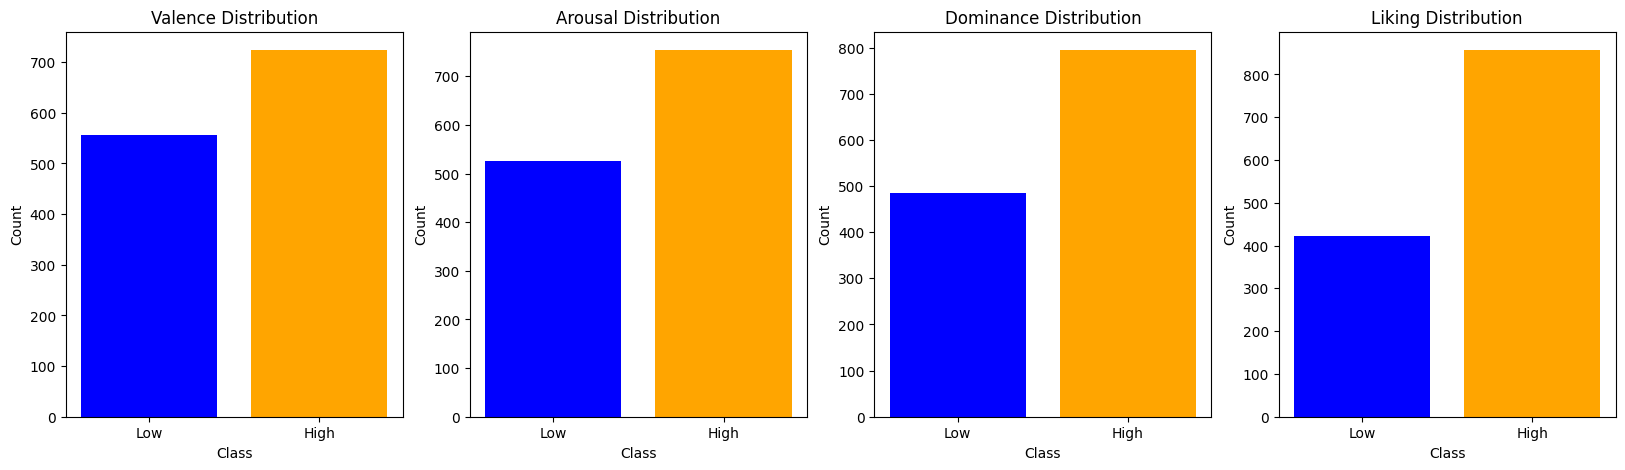

In [59]:
import numpy as np
import matplotlib.pyplot as plt

# Load DEAP labels (Shape: (32, 40, 4)) → (Subjects, Trials, [Valence, Arousal, Dominance, Liking])
deap_labels = np.load("/kaggle/working/de_labels.npy")  # Update path if needed

# Convert continuous labels (0-9) to binary classes (low/high) using 5 as threshold
binary_labels = (deap_labels >= 5).astype(int)  # 1 = High, 0 = Low

# Count occurrences of each class (for each label type)
valence_counts = np.bincount(binary_labels[:, :, 0].flatten(), minlength=2)
arousal_counts = np.bincount(binary_labels[:, :, 1].flatten(), minlength=2)
dominance_counts = np.bincount(binary_labels[:, :, 2].flatten(), minlength=2)
liking_counts = np.bincount(binary_labels[:, :, 3].flatten(), minlength=2)

# Plot class distributions
fig, axes = plt.subplots(1, 4, figsize=(20, 5))
labels = ["Low", "High"]

for i, (counts, title) in enumerate(zip([valence_counts, arousal_counts, dominance_counts, liking_counts], 
                                        ["Valence", "Arousal", "Dominance", "Liking"])):
    axes[i].bar(labels, counts, color=['blue', 'orange'])
    axes[i].set_title(f"{title} Distribution")
    axes[i].set_xlabel("Class")
    axes[i].set_ylabel("Count")

plt.show()


In [52]:
# import torch
# import torch.nn as nn
# import torch.optim as optim
# import torch.nn.functional as F

# # ✅ 1️⃣ Subject-Specific Feature Extractor (SFE)
# class SubjectFeatureExtractor(nn.Module):
#     def __init__(self, input_dim=64, output_dim=32):
#         super(SubjectFeatureExtractor, self).__init__()
#         self.fc = nn.Linear(input_dim, output_dim)
#         self.activation = nn.LeakyReLU()

#     def forward(self, x):
#         return self.activation(self.fc(x))  # Output: (batch, 32)

# # ✅ 2️⃣ Subject-Specific Classifier (SSC)
# class SubjectClassifier(nn.Module):
#     def __init__(self, input_dim=32, num_classes=4):  # 4 classes (Valence, Arousal, Dominance, Liking)
#         super(SubjectClassifier, self).__init__()
#         self.fc = nn.Linear(input_dim, num_classes)  # No activation function

#     def forward(self, x):
#         return self.fc(x)  # Output: (batch, 4)

# # ✅ 3️⃣ Maximum Mean Discrepancy (MMD) Loss
# def mmd_loss(source_features, target_features):
#     """Computes MMD loss to align source & target feature distributions"""
#     source_mean = torch.mean(source_features, dim=0)
#     target_mean = torch.mean(target_features, dim=0)
#     return torch.norm(source_mean - target_mean, p=2) ** 2  # L2 norm squared

# # ✅ 4️⃣ Contrastive Learning with Class Prototypes (L_con2)
# class PrototypeContrastiveLoss(nn.Module):
#     def __init__(self, tau=0.3, gamma=0.5):
#         super(PrototypeContrastiveLoss, self).__init__()
#         self.tau = tau  # Temperature scaling
#         self.gamma = gamma  # Prototype update rate

#     def forward(self, target_features, prototypes, pseudo_labels):
#         if pseudo_labels.numel() == 0:  # If no pseudo-labeled samples, return 0 loss
#             return torch.tensor(0.0, device=target_features.device)

#         batch_size = target_features.shape[0]

#         # Normalize target features and prototypes
#         target_features = F.normalize(target_features, dim=-1)
#         prototypes = F.normalize(prototypes, dim=-1)

#         # Compute cosine similarity between target features & class prototypes
#         sim_matrix = torch.mm(target_features, prototypes.T)  # (batch, num_classes)

#         # Compute softmax-based contrastive loss
#         exp_sim = torch.exp(sim_matrix / self.tau)
#         pos_sim = exp_sim[torch.arange(batch_size), pseudo_labels]  # Positives
#         neg_sim = exp_sim.sum(dim=-1)  # All samples

#         # Compute contrastive loss
#         loss = -torch.log(pos_sim / (neg_sim + 1e-9)).mean()
#         return loss

# # ✅ 5️⃣ Training Setup
# device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# # Initialize models
# sfe = SubjectFeatureExtractor().to(device)
# ssc = SubjectClassifier().to(device)
# contrastive_criterion = PrototypeContrastiveLoss().to(device)

# # Optimizer
# optimizer = optim.Adam(list(sfe.parameters()) + list(ssc.parameters()), lr=0.01)

# # Simulated Input Data (Replace with real features)
# batch_size = 128
# feature_dim = 64  # Input to SFE
# num_classes = 4

# # Load extracted common features
# common_features = torch.randn(batch_size, feature_dim).to(device)  # Simulated input (batch_size, 64)
# labels = torch.randint(0, num_classes, (batch_size,)).to(device)  # Simulated labels

# # Training Loop
# epochs = 50
# for epoch in range(epochs):
#     optimizer.zero_grad()

#     # Step 1: Extract Subject-Specific Features
#     subject_features = sfe(common_features)  # (batch_size, 32)

#     # Step 2: Compute Predictions
#     predictions = ssc(subject_features)  # (batch_size, 4)

#    # Step 3: Compute MMD Loss (For early training iterations)
#     if epoch < 20:  # MMD applied only in early stages
#         source_features = subject_features[:batch_size//2]  # Split batch into source & target
#         target_features = subject_features[batch_size//2:]
#         mmd_loss_value = mmd_loss(source_features, target_features)
#     else:
#         mmd_loss_value = torch.zeros(1, device=device, requires_grad=True)  # ✅ FIXED
    
#     # Step 4: Compute Contrastive Loss (L_con2)
#     contrastive_loss_value = torch.zeros(1, device=device, requires_grad=True)  # ✅ FIXED
    
#     if epoch >= 20:  # Start pseudo-labeling after early training
#         with torch.no_grad():
#             probs = F.softmax(predictions, dim=-1)  # Convert logits to probabilities
#             pseudo_labels = torch.argmax(probs, dim=-1)
#             high_conf_mask = probs.max(dim=-1)[0] > 0.7  # Threshold for pseudo-labeling
#             pseudo_labels = pseudo_labels[high_conf_mask]  # Select high-confidence labels
#             target_features_high_conf = subject_features[high_conf_mask]
    
#         if pseudo_labels.numel() > 0:  # Only compute if there are pseudo-labels
#             # Compute class prototypes (moving average update)
#             class_prototypes = torch.zeros((num_classes, 32), device=device)  # Initialize prototype vectors
#             for c in range(num_classes):
#                 class_samples = subject_features[labels == c]
#                 if class_samples.numel() > 0:
#                     class_prototypes[c] = 0.5 * class_prototypes[c] + 0.5 * class_samples.mean(dim=0)
    
#             contrastive_loss_value = contrastive_criterion(target_features_high_conf, class_prototypes, pseudo_labels)
    
#     # Step 5: Compute Total Loss
#     total_loss = mmd_loss_value + contrastive_loss_value
    
#     # Backpropagation
#     total_loss.backward()
#     optimizer.step()

#     # Print Training Progress (Fixed TypeError)
#     print(f"Epoch {epoch+1}/{epochs} | MMD Loss: {mmd_loss_value.item():.4f} | Contrastive Loss: {contrastive_loss_value.item():.4f} | Total Loss: {total_loss.item():.4f}")


# print("✅ Training Complete!")


Epoch 1/50 | MMD Loss: 0.1525 | Contrastive Loss: 0.0000 | Total Loss: 0.1525
Epoch 2/50 | MMD Loss: 0.0421 | Contrastive Loss: 0.0000 | Total Loss: 0.0421
Epoch 3/50 | MMD Loss: 0.0212 | Contrastive Loss: 0.0000 | Total Loss: 0.0212
Epoch 4/50 | MMD Loss: 0.0266 | Contrastive Loss: 0.0000 | Total Loss: 0.0266
Epoch 5/50 | MMD Loss: 0.0353 | Contrastive Loss: 0.0000 | Total Loss: 0.0353
Epoch 6/50 | MMD Loss: 0.0328 | Contrastive Loss: 0.0000 | Total Loss: 0.0328
Epoch 7/50 | MMD Loss: 0.0219 | Contrastive Loss: 0.0000 | Total Loss: 0.0219
Epoch 8/50 | MMD Loss: 0.0129 | Contrastive Loss: 0.0000 | Total Loss: 0.0129
Epoch 9/50 | MMD Loss: 0.0101 | Contrastive Loss: 0.0000 | Total Loss: 0.0101
Epoch 10/50 | MMD Loss: 0.0097 | Contrastive Loss: 0.0000 | Total Loss: 0.0097
Epoch 11/50 | MMD Loss: 0.0084 | Contrastive Loss: 0.0000 | Total Loss: 0.0084
Epoch 12/50 | MMD Loss: 0.0067 | Contrastive Loss: 0.0000 | Total Loss: 0.0067
Epoch 13/50 | MMD Loss: 0.0070 | Contrastive Loss: 0.0000 | T

In [24]:
def train_mscl(cfe, sfe_list, classifiers, mmd_loss, contrastive_loss_1, contrastive_loss_2, gce_loss, train_loader, optimizer, num_epochs=100):
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    cfe.to(device)
    for sfe, classifier in zip(sfe_list, classifiers):
        sfe.to(device)
        classifier.to(device)

    for epoch in range(num_epochs):
        alpha = 2 / (1 + torch.exp(torch.tensor(-10 * epoch / num_epochs))) - 1  # Correct Dynamic alpha
        beta = alpha / 100  # Dynamic beta
        total_loss = 0

        for iteration, (data, labels, subject_ids) in enumerate(train_loader):
            data, labels = data.to(device), labels.to(device)

            common_features = cfe(data)
            subject_features = torch.stack([sfe_list[subj](common_features) for subj in subject_ids])

            loss_gce, loss_mmd, loss_con1, loss_con2 = 0, 0, 0, 0

            for subj in range(len(sfe_list)):
                subject_mask = (subject_ids == subj)
                if subject_mask.sum() == 0:
                    continue

                subj_features = subject_features[subj][subject_mask]
                subj_labels = labels[subject_mask]
                logits = classifiers[subj](subj_features)
                loss_gce += gce_loss(logits, subj_labels)

                if iteration < 420:
                    loss_mmd += mmd_loss(subj_features, common_features[subject_mask])
                if iteration < 400:
                    loss_con1 += contrastive_loss_1(common_features, subj_labels)
                if iteration >= 420:
                    pseudo_labels = torch.argmax(F.softmax(logits, dim=-1), dim=-1)
                    mask = F.softmax(logits, dim=-1).max(dim=-1).values > 0.7
                    loss_con2 += contrastive_loss_2(subj_features[mask], pseudo_labels[mask])

            total_batch_loss = loss_gce + alpha * loss_mmd + beta * (loss_con1 + loss_con2)
            total_loss += total_batch_loss.item()

            optimizer.zero_grad()
            total_batch_loss.backward()
            optimizer.step()

        print(f"Epoch [{epoch+1}/{num_epochs}], Loss: {total_loss:.4f}, Alpha: {alpha:.4f}, Beta: {beta:.6f}")

    print("Training completed!")

In [25]:
from torch.utils.data import Dataset, DataLoader

class DEAPDataset(Dataset):
    def __init__(self, eeg_data, labels, subject_ids):
        self.eeg_data = torch.tensor(eeg_data, dtype=torch.float32)
        self.labels = torch.tensor(labels, dtype=torch.long)
        self.subject_ids = torch.tensor(subject_ids, dtype=torch.long)

    def __len__(self):
        return len(self.eeg_data)

    def __getitem__(self, idx):
        return self.eeg_data[idx], self.labels[idx], self.subject_ids[idx]

# Generate subject IDs
subject_ids = np.repeat(np.arange(num_participants), 40)  # 40 trials per participant

# Create dataset and DataLoader
train_dataset = DEAPDataset(all_data.reshape(-1, 200), all_labels.reshape(-1, 4), subject_ids)
train_loader = DataLoader(train_dataset, batch_size=128, shuffle=True)


In [26]:
# Initialize models
input_dim = 200  # Feature size after DE extraction
num_classes = 4  # Valence, Arousal, Dominance, Liking
num_subjects = num_participants  # Number of subjects

cfe = CommonFeatureExtractor(input_dim)  # Common Feature Extractor
sfe_list = [SubjectFeatureExtractor() for _ in range(num_subjects)]  # Subject-Specific Feature Extractors
classifiers = [SubjectClassifier(num_classes=num_classes) for _ in range(num_subjects)]  # Subject Classifiers

# Loss functions
mmd_loss = MMDLoss()
contrastive_loss_1 = ContrastiveLoss(temperature=0.1)
contrastive_loss_2 = ContrastiveLoss(temperature=0.3)
gce_loss = GCELoss(q=0.55)

# Optimizer
optimizer = optim.Adam(
    list(cfe.parameters()) + 
    [p for sfe in sfe_list for p in sfe.parameters()] +
    [p for cls in classifiers for p in cls.parameters()],
    lr=0.01
)

# Example DataLoader (Replace with actual dataset)
#train_loader = torch.utils.data.DataLoader(all_data, batch_size=128, shuffle=True)

# === Run Leave-One-Out Training on DEAP ===
for leave_out in range(num_participants):
    print(f"Training with Participant {leave_out} as Target")
    train_mscl(cfe, sfe_list, classifiers, mmd_loss, contrastive_loss_1, contrastive_loss_2, gce_loss, train_loader, optimizer)


Training with Participant 0 as Target


RuntimeError: Size does not match at dimension 0 expected index [4, 1] to be smaller than self [1, 4] apart from dimension 1